In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
count = {}
for dirname, _, filenames in os.walk('/kaggle/input/deeplense-specific-data/lens-finding/train_lenses'):
    count['train_lenses']=[os.path.join('/kaggle/input/deeplense-specific-data/lens-finding/train_lenses',f) for f in filenames]
for dirname, _, filenames in os.walk('/kaggle/input/deeplense-specific-data/lens-finding/train_nonlenses'):
    count['train_nonlenses']=[os.path.join('/kaggle/input/deeplense-specific-data/lens-finding/train_nonlenses',f) for f in filenames]

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

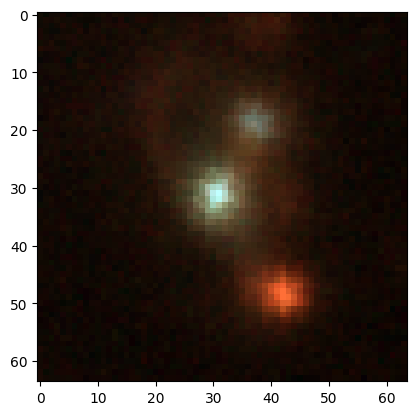

In [2]:
sample_l = np.load(count['train_lenses'][4])
plt.imshow(sample_l.transpose(1,2,0))

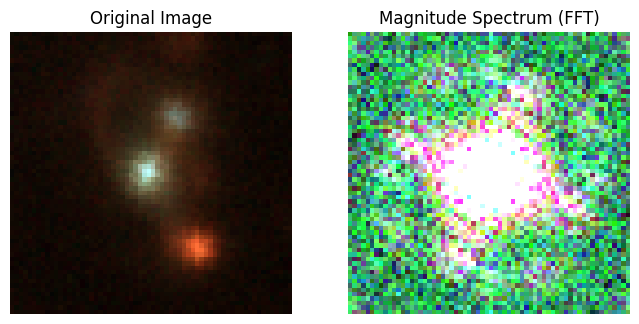

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the 2D FFT
fft_image = np.fft.fft2(sample_l)
fft_shifted = np.fft.fftshift(fft_image)

# Compute magnitude spectrum
magnitude_spectrum = np.log(1 + np.abs(fft_shifted))

# Visualize
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sample_l.transpose(1,2,0))  # Original Image
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(magnitude_spectrum.transpose(1,2,0))  # Average across channels
plt.title("Magnitude Spectrum (FFT)")
plt.axis("off")

plt.show()

In [4]:
# train_l = np.concatenate([np.load(f) for f in count['train_lenses']])
# train_nl = np.concatenate([np.load(f) for f in count['train_nonlenses']])

In [5]:
# train_nl.shape

In [6]:
# Lens Classification Notebook
# A state-of-the-art, customizable PyTorch implementation for lens classification

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
import copy
import time
import timm
from transformers import AutoModel, AutoImageProcessor

# Setting the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set the seed for reproducibility (Cell 1)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed()

# Configuration parameters (can be easily modified)
config = {
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'val_split': 0.2,
    'seed': 42,
    'model_name': 'efficientnet_b0',  # Options: 'resnet18', 'crop_view' 'efficient_fft_attention' 'fftaugmented' 'efficient_attention' 'dinov2-variants', 'resnet50', 'efficientnet_b0', 'densenet121', 'custom_cnn'
    'freeze_backbone': False,
    'optimizer': 'adam',  # Options: 'adam', 'sgd', 'adamw'
    'scheduler': 'cosine',  # Options: 'step', 'cosine', 'none'
    'early_stopping_patience': 10,
    'weight_decay': 1e-4,
    'dropout_rate': 0,
    'img_size': 64,
    'save_path': './saved_models',
    'num_workers': 4,
    'augmentation_level': 'heavy',  # Options: 'none', 'light', 'medium', 'heavy'
    'rotation': 360,
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    'use_attention': False,
    'loss_function': 'bce',  #Options: 'bce', 'pin'
    'einstien_check': False,
    'modified_relu': True,
}
ensemble_config = {
    'weights': [0.5,0.5,0.5],
    'use_weights':False
}

Using device: cuda:0


In [7]:
# Custom Dataset class for loading .npy files (Cell 2)
set_seed(config['seed'])

class LensDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        """
        Args:
            file_paths (list): List of paths to .npy files
            labels (list): List of labels corresponding to file_paths
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load the npy file
        image = np.load(self.file_paths[idx])
        
        # Convert to PyTorch tensor (C, H, W)
        image = torch.from_numpy(image).float()
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[idx]

In [8]:
# Data loading and preprocessing function (Cell 3)
set_seed(config['seed'])

def prepare_data(train_lenses, train_nonlenses, config):
    """
    Prepare the datasets and dataloaders
    
    Args:
        train_lenses (list): List of file paths to lens data
        train_nonlenses (list): List of file paths to non-lens data
        config (dict): Configuration parameters
        
    Returns:
        train_loader, val_loader: DataLoader objects for training and validation
    """
    # Create file paths and labels lists
    all_file_paths = train_lenses + train_nonlenses
    all_labels = [1] * len(train_lenses) + [0] * len(train_nonlenses)
    
    # Define augmentations based on the selected level
    if config['augmentation_level'] == 'none':
        transform = transforms.Compose([
            transforms.Normalize(mean=config['mean'], std=config['std'])
        ])
    elif config['augmentation_level'] == 'light':
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(mean=config['mean'], std=config['std'])
        ])
    elif config['augmentation_level'] == 'medium':
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(config['rotation']),
            transforms.Normalize(mean=config['mean'], std=config['std'])
        ])
    else:  # heavy
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(config['rotation']),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.Normalize(mean=config['mean'], std=config['std'])
        ])
    
    # Create the full dataset
    full_dataset = LensDataset(all_file_paths, all_labels, transform=transform)
    
    # Split into train and validation sets
    val_size = int(config['val_split'] * len(full_dataset))
    train_size = len(full_dataset) - val_size
    
    train_dataset, val_dataset = random_split(
        full_dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(config['seed'])
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True, 
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    return train_loader, val_loader

In [9]:
# Data visualization function (Cell 4)
set_seed(config['seed'])

def visualize_data(data_loader, num_images=5):
    """
    Visualize samples from the dataset
    
    Args:
        data_loader: DataLoader object to visualize samples from
        num_images (int): Number of images to visualize
    """
    # Get a batch of data
    images, labels = next(iter(data_loader))
    
    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    # Display the images
    for i in range(num_images):
        if i < len(images):
            # Convert the tensor to a numpy array and transpose to (H, W, C) for display
            img = images[i].numpy()
            
            # Normalize the image for visualization
            img = (img - img.min()) / (img.max() - img.min())
            
            # Display the image
            axes[i].imshow(np.transpose(img, (1, 2, 0)))
            axes[i].set_title(f"Class: {'Lens' if labels[i] == 1 else 'Non-Lens'}")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot class distribution
    all_labels = []
    for _, batch_labels in data_loader:
        all_labels.extend(batch_labels.numpy())
    
    # Count labels
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    
    # Plot class distribution
    plt.figure(figsize=(8, 5))
    plt.bar(['Non-Lens', 'Lens'], [counts[0], counts[1]], color=['skyblue', 'salmon'])
    plt.title('Class Distribution')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [10]:
class dinov2(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.processor = AutoImageProcessor.from_pretrained(f"facebook/{config['model_name']}")
        self.model = AutoModel.from_pretrained(f"facebook/{config['model_name']}")
        if config['freeze_backbone']:
            for param in self.model.parameters():
                param.requires_grad = False
        self.fc = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(self.model.config.hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        inputs = self.processor(images=x, return_tensors="pt").to(device)
        outputs = self.model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return self.fc(cls_embedding)

In [11]:
class efficient_attention(nn.Module):
    def __init__(self, num_classes=1, use_attention=True):
        super().__init__()
        # Backbone: EfficientNet-B0
        self.backbone = models.efficientnet_b0(pretrained=True).features
        self.use_attention = use_attention
        
        # Physics-Guided Attention
        if self.use_attention:
            self.radial_mask = self._create_radial_mask(64)  # For input size 64x64
            self.channel_att = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(3, 16, 1), nn.ReLU(),
                nn.Conv2d(16, 3, 1), nn.Sigmoid()
            )
        
        # Classification & Regression Heads
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(1280, num_classes),
            nn.Sigmoid()
        )
        self.radius_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(1280, 1)
        )

    def _create_radial_mask(self, size):
        """Fixed Gaussian mask to focus on central regions"""
        xx, yy = torch.meshgrid(torch.arange(size), torch.arange(size))
        mask = torch.exp(-((xx - size//2)**2 + (yy - size//2)**2)/(2*(size//4)**2))
        return mask.unsqueeze(0)  # Shape: (1, H, W)

    def forward(self, x):
        # Apply attention
        if self.use_attention:
            x = x * self.radial_mask.to(x.device)  # Radial bias
            channel_weights = self.channel_att(x)
            x = x * channel_weights
        
        # Backbone features
        features = self.backbone(x)
        
        # Outputs
        cls_logits = self.classifier(features)
        radius = self.radius_head(features)
        return cls_logits, radius

In [12]:
class FFTAugmentedModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial branch (original RGB)
        self.spatial_branch = models.efficientnet_b0(pretrained=True).features
        
        # Frequency branch (FFT magnitudes)
        self.freq_branch = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(4*1280 + 32*32*32, 1),
            nn.Sigmoid()
        )  # Adjust dimensions

    def forward(self, x):
        # Spatial features
        spatial_feat = self.spatial_branch(x)
        
        
        # Frequency features
        fft = torch.fft.fft2(x, dim=(-2, -1))
        fft_mag = torch.log(1 + torch.abs(fft))  # Log-scale magnitudes
        freq_feat = self.freq_branch(fft_mag)
        
        # Concatenate & classify
        combined = torch.cat([spatial_feat.flatten(1), 
                             freq_feat.flatten(1)], dim=1)
        
        return self.classifier(combined)

In [13]:
class efficient_fft_attention(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        # Backbone: EfficientNet-B0
        self.backbone = models.efficientnet_b0(pretrained=True).features
        
        # Physics-Guided Attention
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(3, 16, 1), nn.ReLU(),
            nn.Conv2d(16, 3, 1), nn.Sigmoid()
        )
        
        # Classification & Regression Heads
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(1280, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Apply attention
        fft = torch.fft.fft2(x, dim=(-2, -1))
        fft_mag = torch.log(1 + torch.abs(fft))
        channel_weights = self.channel_att(fft_mag)
        x = x * channel_weights
        
        # Backbone features
        features = self.backbone(x)
        
        # Outputs
        cls_logits = self.classifier(features)
        return cls_logits

In [14]:

class crop_view(nn.Module):
    def __init__(self):
        super().__init__()
        # Full-image branch (64x64 input)
        self.full_net = self._build_effnet()
        
        # Center-crop branch (32x32 input)
        self.crop_net = self._build_effnet()
        
        # Classifier (combines both branches)
        self.classifier = nn.Sequential(
            nn.Linear(2560, 512),  # 1280 (full) + 1280 (crop) = 2560
            nn.ReLU(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def _build_effnet(self):
        """EfficientNet-B0 without classifier + adjusted for small inputs"""
        model = models.efficientnet_b0(pretrained=False)
        model.classifier = nn.Identity()  # Remove final FC layer
        
        # Modify stem convolution for smaller inputs
        model.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        return model

    def forward(self, x):
        # Full-image branch
        full_feat = self.full_net(x)
        
        # Center crop (32x32 from 64x64 input)
        _, _, H, W = x.shape
        x_crop = x[:, :, H//4:3*H//4, W//4:3*W//4]  # Center 32x32
        
        # Crop branch
        crop_feat = self.crop_net(x_crop)
        
        # Combine and classify
        combined = torch.cat([full_feat, crop_feat], dim=1)
        return self.classifier(combined)

In [15]:
class ModifiedReLU(nn.Module):
    def forward(self, x):
        return (1 / torch.sqrt(torch.tensor(torch.pi - 1))) * (torch.sqrt(2 * torch.tensor(torch.pi)) * torch.relu(x) - 1)

In [16]:
def replace_activation(model, new_activation):
    for name, module in model.named_children():
        if isinstance(module, (nn.SiLU, nn.ReLU)):  
            setattr(model, name, new_activation)
        else:
            replace_activation(module, new_activation)
    return model

In [17]:
# Model definition function (Cell 5)
set_seed(config['seed'])

def create_model(config):
    """
    Create a model based on the configuration
    
    Args:
        config (dict): Configuration parameters
        
    Returns:
        model (nn.Module): The created model
    """
    if config['model_name'] == 'resnet18':
        model = models.resnet18(weights='DEFAULT')
        if config['freeze_backbone']:
            for param in model.parameters():
                param.requires_grad = False
        # Modify the final layer for binary classification
        model.fc = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(model.fc.in_features, 1),
            nn.Sigmoid()
        )

    elif config['model_name'].startswith('dinov2'):
        model = dinov2(config)

    elif config['model_name'] == 'efficient_attention':
        model = efficient_attention(use_attention = config['use_attention'])

    elif config['model_name'] == 'fftaugmented':
        model = FFTAugmentedModel()

    elif config['model_name'] == 'efficient_fft_attention':
        model = efficient_fft_attention()

    elif config['model_name'] == 'crop_view':
        model = crop_view()
    
    elif config['model_name'] == 'resnet50':
        model = models.resnet50(weights='DEFAULT')
        if config['freeze_backbone']:
            for param in model.parameters():
                param.requires_grad = False
        # Modify the final layer
        model.fc = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(model.fc.in_features, 1),
            nn.Sigmoid()
        )
    
    elif config['model_name'] == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='DEFAULT')
        if config['freeze_backbone']:
            for param in model.parameters():
                param.requires_grad = False
        # Modify the classifier
        model.classifier = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(model.classifier[1].in_features, 1),
            nn.Sigmoid()
        )
    
    elif config['model_name'] == 'densenet121':
        model = models.densenet121(weights='DEFAULT')
        if config['freeze_backbone']:
            for param in model.parameters():
                param.requires_grad = False
        # Modify the classifier
        model.classifier = nn.Sequential(
            nn.Dropout(config['dropout_rate']),
            nn.Linear(model.classifier.in_features, 1),
            nn.Sigmoid()
        )
    
    elif config['model_name'] == 'custom_cnn':
        # Define a custom CNN architecture
        model = nn.Sequential(
            # Input shape: (3, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 32, 32)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 16, 16)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 8, 8)
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 4, 4)
            
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    else:
        raise ValueError(f"Model {config['model_name']} not supported")
    try:
        if config['modified_relu']:
            model = replace_activation(model, ModifiedReLU())
    except:
        pass
    
    # Move model to device
    model = model.to(device)
    print(f"Created {config['model_name']} model")
    
    return model

In [18]:
# Define optimizer and scheduler (Cell 6)
set_seed(config['seed'])

def get_optimizer_and_scheduler(model, config):
    """
    Create an optimizer and learning rate scheduler based on the configuration
    
    Args:
        model (nn.Module): The model to optimize
        config (dict): Configuration parameters
        
    Returns:
        optimizer, scheduler: The created optimizer and scheduler
    """
    # Create optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(
            model.parameters(), 
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
    elif config['optimizer'] == 'sgd':
        optimizer = optim.SGD(
            model.parameters(), 
            lr=config['learning_rate'],
            momentum=0.9,
            weight_decay=config['weight_decay']
        )
    elif config['optimizer'] == 'adamw':
        optimizer = optim.AdamW(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
    else:
        raise ValueError(f"Optimizer {config['optimizer']} not supported")
    
    # Create scheduler
    if config['scheduler'] == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    elif config['scheduler'] == 'cosine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['num_epochs'])
    elif config['scheduler'] == 'none':
        scheduler = None
    else:
        raise ValueError(f"Scheduler {config['scheduler']} not supported")
    
    return optimizer, scheduler

In [19]:
class PhysicsAwareLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.1):
        super().__init__()
        self.focal_loss = nn.BCELoss()  # Handle class imbalance
        self.alpha = alpha  # Weight for radius penalty
        # self.beta = beta    # Weight for asymmetry loss
        
    def forward(self, outputs, targets):
        cls_logits, radius_pred = outputs
        cls_loss = self.focal_loss(cls_logits, targets)
        
        # Radius constraint (valid range: 0.5-5 arcseconds)
        radius_penalty = torch.mean(
            torch.clamp(radius_pred - 5, min=0) + 
            torch.clamp(0.5 - radius_pred, min=0)
        )
        
        # # Asymmetry loss (using Sobel filters)
        # sobel_x = torch.tensor([[[[-1,0,1], [-2,0,2], [-1,0,1]]]], dtype=torch.float32)
        # sobel_y = torch.tensor([[[[-1,-2,-1], [0,0,0], [1,2,1]]]], dtype=torch.float32)
        # grad_x = torch.abs(nn.functional.conv2d(features, sobel_x.to(features.device)))
        # grad_y = torch.abs(nn.functional.conv2d(features, sobel_y.to(features.device)))
        # asymmetry = torch.mean((grad_x - grad_y)**2)
        
        total_loss = (cls_loss + 
                     self.alpha * radius_penalty)
                     # self.beta * asymmetry)
        return total_loss

In [20]:
def erc(r):
    if config['einstien_check']:
        return (r >= 0.5) & (r <= 5)
    else:
        return r==r

In [21]:
# Training function (Cell 7)
set_seed(config['seed'])

def train_model(model, train_loader, val_loader, config):
    """
    Train the model
    
    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): DataLoader for training data
        val_loader (DataLoader): DataLoader for validation data
        config (dict): Configuration parameters
        
    Returns:
        model (nn.Module): The trained model
        history (dict): Training history
    """
    # Create optimizer and scheduler
    optimizer, scheduler = get_optimizer_and_scheduler(model, config)
    
    # Define loss function
    if config['loss_function'] == 'bce':
        criterion = nn.BCELoss()

    elif config['loss_function'] == 'pin':
        criterion = PhysicsAwareLoss()
    
    # Initialize the best model weights and validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_auc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    # Initialize history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'val_roc_auc': []  # Added ROC AUC metric
    }
    
    # Training loop
    for epoch in range(config['num_epochs']):
        print(f'Epoch {epoch+1}/{config["num_epochs"]}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over the training data
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.float().to(device).view(-1, 1)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass + optimize
                loss.backward()
                optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            preds = ((outputs[0] > 0.5) & erc(outputs[1])).float() if type(outputs)==tuple else (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)
        
        if scheduler is not None:
            scheduler.step()
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_preds = []
        val_labels = []
        val_scores = []  # Added for ROC AUC calculation
        
        # Iterate over the validation data
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.float().to(device).view(-1, 1)
            
            # Forward pass
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Statistics
            val_running_loss += loss.item() * inputs.size(0)
            preds = ((outputs[0] > 0.5) & erc(outputs[1])).float() if type(outputs)==tuple else (outputs > 0.5).float()
            
            # Collect predictions, raw scores, and labels for metrics
            val_preds.extend(preds.cpu().numpy())
            val_scores.extend(outputs[0].cpu().numpy() if type(outputs)==tuple else outputs.cpu().numpy())  # Raw scores for ROC AUC
            val_labels.extend(labels.cpu().numpy())
        
        # Calculate validation statistics
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_preds = np.array(val_preds).flatten()
        val_scores = np.array(val_scores).flatten()  # Convert to numpy array
        val_labels = np.array(val_labels).flatten()
        
        val_acc = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, zero_division=0)
        val_recall = recall_score(val_labels, val_preds, zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, zero_division=0)
        
        # Calculate ROC AUC
        from sklearn.metrics import roc_auc_score
        val_roc_auc = roc_auc_score(val_labels, val_scores)
        
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {val_f1:.4f} ROC AUC: {val_roc_auc:.4f}')
        
        # Update history
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        history['val_roc_auc'].append(val_roc_auc)  # Add ROC AUC to history
        
        # If validation accuracy improved, save the model weights
        if val_roc_auc > best_val_auc:
            best_val_auc = val_roc_auc
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= config['early_stopping_patience']:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break
            
        print()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f'Best validation auc: {best_val_auc:.4f} achieved at epoch {best_epoch+1}')
    
    return model, history

In [22]:
# Evaluation function (Cell 8)
set_seed(config['seed'])

def evaluate_model(model, data_loader):
    """
    Evaluate the model on the given data loader
    
    Args:
        model (nn.Module): The model to evaluate
        data_loader (DataLoader): DataLoader for evaluation data
        
    Returns:
        metrics (dict): Evaluation metrics
    """
    model.eval()
    all_preds = []
    all_scores = []  # Added to store raw prediction scores
    all_labels = []
    
    # Collect predictions and labels
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            
            # Forward pass
            outputs = model(inputs)
            preds = ((outputs[0] > 0.5) & erc(outputs[1])).float() if type(outputs)==tuple else (outputs > 0.5).float()
            
            # Collect predictions, raw scores, and labels
            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(outputs[0].cpu().numpy() if type(outputs)==tuple else outputs.cpu().numpy())  # Save raw scores for ROC AUC
            all_labels.extend(labels.numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_scores = np.array(all_scores).flatten()
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate ROC AUC
    from sklearn.metrics import roc_auc_score, roc_curve, auc
    roc_auc = roc_auc_score(all_labels, all_scores)
    
    # Print results
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    
    # Create figure with subplots
    plt.figure(figsize=(15, 6))
    
    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Lens', 'Lens'],
                yticklabels=['Non-Lens', 'Lens'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    # Plot ROC curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics
    metrics = {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,  # Added ROC AUC to metrics
        'confusion_matrix': cm
    }
    
    return metrics

In [23]:
# Plot training history (Cell 9)
set_seed(config['seed'])

def plot_training_history(history):
    """
    Plot the training history
    
    Args:
        history (dict): Training history
    """
    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.6)
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    # Plot validation metrics
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 4, 1)
    plt.plot(history['val_precision'], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Validation Precision')
    plt.grid(linestyle='--', alpha=0.6)
    
    plt.subplot(1, 4, 2)
    plt.plot(history['val_recall'], marker='o', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Validation Recall')
    plt.grid(linestyle='--', alpha=0.6)
    
    plt.subplot(1, 4, 3)
    plt.plot(history['val_f1'], marker='o', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.grid(linestyle='--', alpha=0.6)
    
    # Add ROC AUC plot
    plt.subplot(1, 4, 4)
    plt.plot(history['val_roc_auc'], marker='o', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC')
    plt.title('Validation ROC AUC')
    plt.grid(linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

In [24]:
# Save and load model functions (Cell 10)
set_seed(config['seed'])

def save_model(model, config, metrics, history, filename=None):
    """
    Save the trained model and related data
    
    Args:
        model (nn.Module): The model to save
        config (dict): Configuration parameters
        metrics (dict): Evaluation metrics
        history (dict): Training history
        filename (str, optional): Specific filename to use
    """
    # Create save directory if it doesn't exist
    os.makedirs(config['save_path'], exist_ok=True)
    
    # Generate filename if not provided
    if filename is None:
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        filename = f"{config['model_name']}_{timestamp}"
    
    # Save model state dict
    model_path = os.path.join(config['save_path'], f"{filename}_model.pth")
    torch.save(model.state_dict(), model_path)
    
    # Save config, metrics, and history
    metadata = {
        'config': config,
        'metrics': metrics,
        'history': history
    }
    metadata_path = os.path.join(config['save_path'], f"{filename}_metadata.pth")
    torch.save(metadata, metadata_path)
    
    print(f"Model saved to {model_path}")
    print(f"Metadata saved to {metadata_path}")

def load_model(model_path, metadata_path=None):
    """
    Load a saved model and related data
    
    Args:
        model_path (str): Path to the saved model
        metadata_path (str, optional): Path to the saved metadata
        
    Returns:
        model (nn.Module): The loaded model
        metadata (dict, optional): The loaded metadata if metadata_path is provided
    """
    # Load metadata if path is provided
    metadata = None
    if metadata_path is not None:
        metadata = torch.load(metadata_path)
        config = metadata['config']
        
        # Create model with the saved configuration
        model = create_model(config)
    else:
        # Create a default model if no metadata is provided
        model = models.resnet18(weights=None)
        model.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(model.fc.in_features, 1),
            nn.Sigmoid()
        )
        model = model.to(device)
    
    # Load model weights
    model.load_state_dict(torch.load(model_path))
    
    print(f"Model loaded from {model_path}")
    if metadata_path is not None:
        print(f"Metadata loaded from {metadata_path}")
    
    return model, metadata

In [25]:
class ensemble(nn.Module):
    def __init__(self, paths):
        super().__init__()
        models = []
        for path,model_path in paths:
            metadata = torch.load(path)
            config = metadata['config']
            
            # Create model with the saved configuration
            model = create_model(config)
            model.load_state_dict(torch.load(model_path))
            models.append(model)
        self.models = nn.ModuleList(models)
        self.weights = torch.tensor(ensemble_config['weights'], dtype=torch.float32, device=device).view(-1, 1, 1) 
        
    def forward(self, x):
        outputs = torch.stack([model(x) for model in self.models], dim=0)  # Shape: (num_models, batch_size, 1)
        if ensemble_config['use_weights']:
            weighted_outputs = outputs * self.weights  # Element-wise multiplication
            avg_output = weighted_outputs.sum(dim=0)  # Averaging probabilities
        else:
            avg_output = outputs.mean(dim=0)
        return avg_output
        

In [26]:
# Example usage of the functions (Cell 11)
set_seed(config['seed'])

# Example usage (uncomment when needed)

# Assuming we have the dictionary with file paths
data_dict = count

# Prepare data
train_loader, val_loader = prepare_data(
    data_dict['train_lenses'], 
    data_dict['train_nonlenses'], 
    config
)

Training samples: 24324
Validation samples: 6081


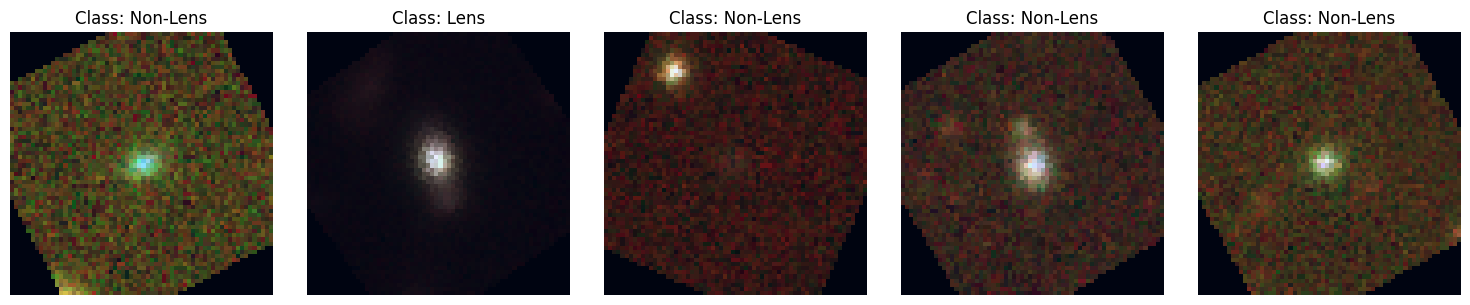

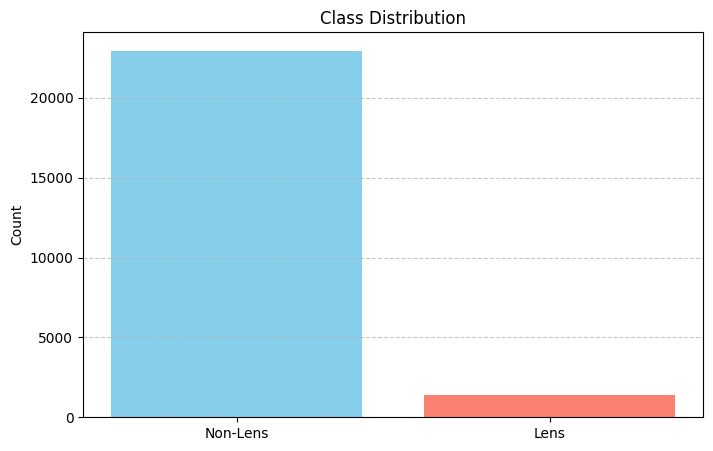

In [27]:
# set_seed(config['seed'])
# Visualize some samples
visualize_data(train_loader)

In [48]:
set_seed(config['seed'])
# Create model
ensemble_paths = []
# ensemble_paths.append(('/kaggle/input/effnet-modified-activation/results-2/saved_models/efficientnet_b0_20250326-130851_metadata.pth','/kaggle/input/effnet-modified-activation/results-2/saved_models/efficientnet_b0_20250326-130851_model.pth'))
# ensemble_paths.append(('/kaggle/input/effnet-old-activation/results-3/saved_models/efficientnet_b0_20250325-154829_metadata.pth','/kaggle/input/effnet-old-activation/results-3/saved_models/efficientnet_b0_20250325-154829_model.pth'))
ensemble_paths.append(('/kaggle/input/effnet-modeifiedrelu-50-epoch/results-4/saved_models/efficientnet_b0_20250326-140126_metadata.pth','/kaggle/input/effnet-modeifiedrelu-50-epoch/results-4/saved_models/efficientnet_b0_20250326-140126_model.pth'))
ensemble_paths.append(('/kaggle/input/effnet-old-relu-50-epoch/results-5/saved_models/efficientnet_b0_20250326-121241_metadata.pth','/kaggle/input/effnet-old-relu-50-epoch/results-5/saved_models/efficientnet_b0_20250326-121241_model.pth'))
# ensemble_paths.append(('/kaggle/input/resnet50-30-epoch/results-6/saved_models/resnet50_20250327-194118_metadata.pth','/kaggle/input/resnet50-30-epoch/results-6/saved_models/resnet50_20250327-194118_model.pth'))
# ensemble_paths.append(('/kaggle/input/densnet121/results-8/saved_models/densenet121_20250324-132725_metadata.pth','/kaggle/input/densnet121/results-8/saved_models/densenet121_20250324-132725_model.pth'))
# ensemble_paths.append(('/kaggle/input/eff-fft-att-modified-relu/results-10/saved_models/efficient_fft_attention_20250326-130107_metadata.pth','/kaggle/input/eff-fft-att-modified-relu/results-10/saved_models/efficient_fft_attention_20250326-130107_model.pth'))
# ensemble_paths.append(('/kaggle/input/fft-augmented/results-7/saved_models/fftaugmented_20250326-115314_metadata.pth','/kaggle/input/fft-augmented/results-7/saved_models/fftaugmented_20250326-115314_model.pth'))
# ensemble_paths.append(('/kaggle/input/crop-view/results-11/saved_models/crop_view_20250326-144428_metadata.pth','/kaggle/input/crop-view/results-11/saved_models/crop_view_20250326-144428_model.pth'))
ensemble_paths.append(('/kaggle/input/resnet-50-50-epoch/results-12/saved_models/resnet50_20250328-133650_metadata.pth','/kaggle/input/resnet-50-50-epoch/results-12/saved_models/resnet50_20250328-133650_model.pth'))
trained_model = ensemble(ensemble_paths)

# Train model
# trained_model, history = train_model(model, train_loader, val_loader, config)

<ipython-input-25-d7b57013df61>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metadata = torch.load(path)
<ipython-input-25-d7b57013df61>:11: FutureWarning: You are using

Created efficientnet_b0 model
Created efficientnet_b0 model
Created resnet50 model


Evaluating:   0%|          | 0/191 [00:00<?, ?it/s]

Accuracy: 0.9883
Precision: 0.9311
Recall: 0.8663
F1 Score: 0.8975
ROC AUC: 0.9942


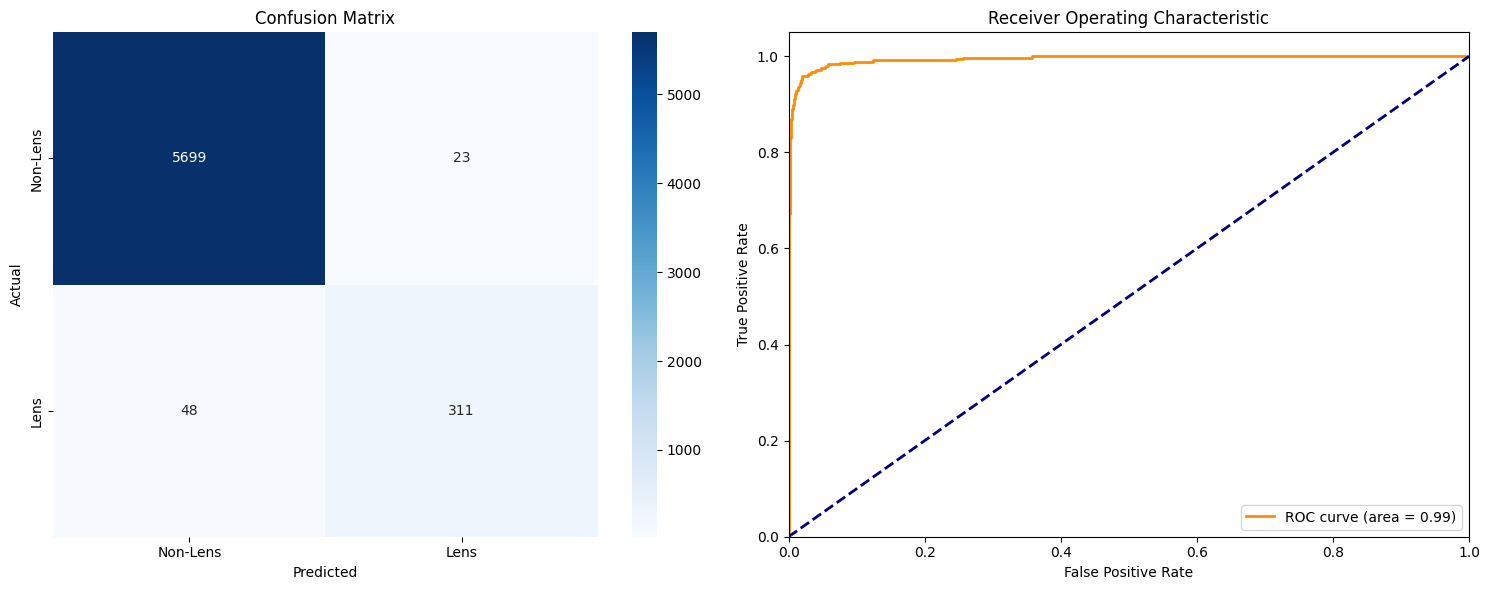

In [49]:
# Evaluate model
metrics = evaluate_model(trained_model, val_loader)

# Plot training history
# plot_training_history(history)

# Save model
# save_model(trained_model, config, metrics, history)

# Load model (example)
# loaded_model, metadata = load_model(
#     os.path.join(config['save_path'], 'resnet18_20250324-120000_model.pth'),
#     os.path.join(config['save_path'], 'resnet18_20250324-120000_metadata.pth')
# )

In [30]:
import os
count_test = {}
for dirname, _, filenames in os.walk('/kaggle/input/deeplense-specific-data/lens-finding/test_lenses'):
    count_test['test_lenses']=[os.path.join('/kaggle/input/deeplense-specific-data/lens-finding/test_lenses',f) for f in filenames]
for dirname, _, filenames in os.walk('/kaggle/input/deeplense-specific-data/lens-finding/test_nonlenses'):
    count_test['test_nonlenses']=[os.path.join('/kaggle/input/deeplense-specific-data/lens-finding/test_nonlenses',f) for f in filenames]

In [31]:
# Test set evaluation (Cell 14)
set_seed(config['seed'])

def prepare_test_data(test_lenses, test_nonlenses, config):
    """
    Prepare the test dataset
    
    Args:
        test_lenses (list): List of file paths to test lens data
        test_nonlenses (list): List of file paths to test non-lens data
        config (dict): Configuration parameters
        
    Returns:
        test_loader: DataLoader for test data
    """
    # Create file paths and labels lists
    test_file_paths = test_lenses + test_nonlenses
    test_labels = [1] * len(test_lenses) + [0] * len(test_nonlenses)
    
    # Use a simple normalization transform for test data (no augmentation)
    transform = transforms.Compose([
        transforms.Normalize(mean=config['mean'], std=config['std'])
    ])
    
    # Create the test dataset
    test_dataset = LensDataset(test_file_paths, test_labels, transform=transform)
    
    # Create data loader
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    print(f"Test samples: {len(test_dataset)}")
    print(f"Lens samples: {len(test_lenses)}")
    print(f"Non-lens samples: {len(test_nonlenses)}")
    
    return test_loader

def evaluate_on_test_set(model, test_lenses, test_nonlenses, config):
    """
    Evaluate a trained model on the test set
    
    Args:
        model: Trained PyTorch model
        test_lenses: List of lens test file paths
        test_nonlenses: List of non-lens test file paths
        config: Configuration dictionary
        
    Returns:
        test_metrics: Dictionary of test metrics
    """
    print("Evaluating model on test set...")
    
    # Prepare test data
    test_loader = prepare_test_data(test_lenses, test_nonlenses, config)
    
    # Evaluate on test data
    test_metrics = evaluate_model(model, test_loader)
    
    # Print summary
    print("\nTest Set Evaluation Summary:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")
    
    return test_metrics

Evaluating model on test set...
Test samples: 19650
Lens samples: 195
Non-lens samples: 19455


Evaluating:   0%|          | 0/615 [00:00<?, ?it/s]

Accuracy: 0.9937
Precision: 0.6385
Recall: 0.8513
F1 Score: 0.7297
ROC AUC: 0.9930


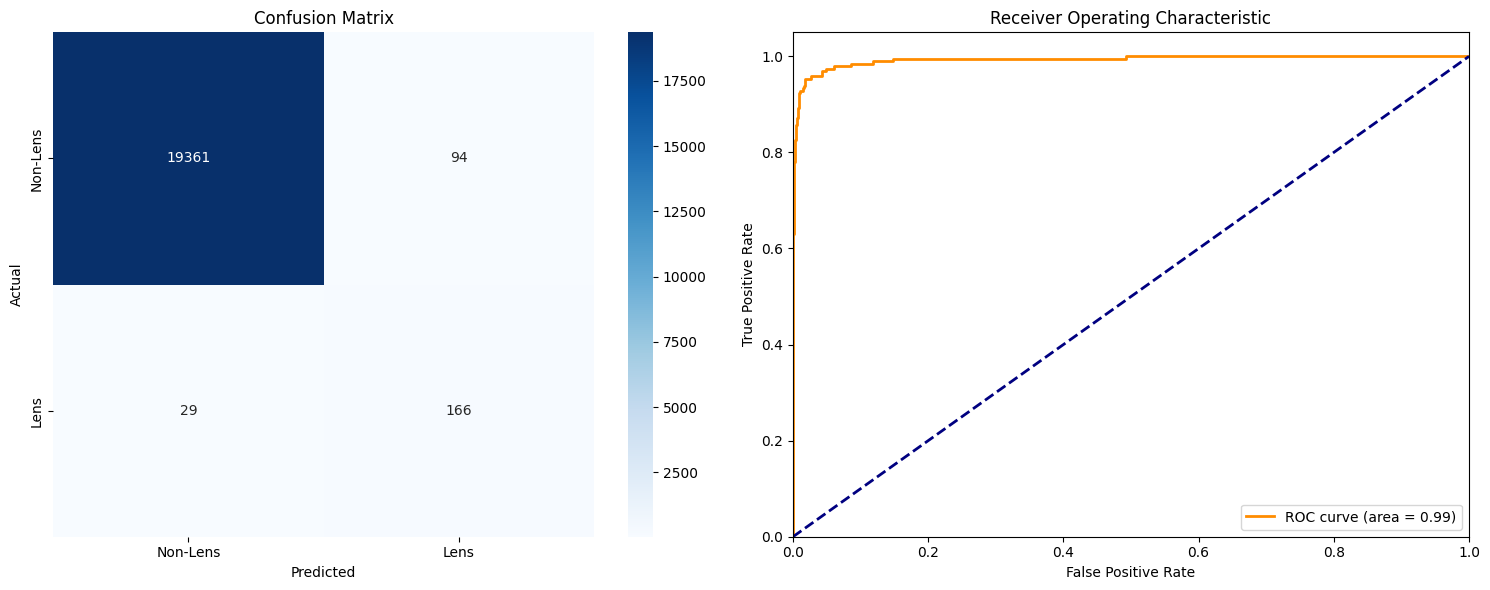


Test Set Evaluation Summary:
Accuracy: 0.9937
Precision: 0.6385
Recall: 0.8513
F1 Score: 0.7297
ROC AUC: 0.9930


In [50]:
set_seed(config['seed'])
# Example usage:
test_dict = count_test

test_metrics = evaluate_on_test_set(trained_model, 
                                    test_dict['test_lenses'], 
                                    test_dict['test_nonlenses'],
                                    config)

In [33]:
# Full training pipeline (Cell 12)
set_seed(config['seed'])

def run_full_pipeline(data_dict, config):
    """
    Run the full training pipeline
    
    Args:
        data_dict (dict): Dictionary with 'train_lenses' and 'train_nonlenses' keys
        config (dict): Configuration parameters
    """
    # Prepare data
    train_loader, val_loader = prepare_data(
        data_dict['train_lenses'], 
        data_dict['train_nonlenses'], 
        config
    )
    
    # Visualize some samples
    visualize_data(train_loader)
    
    # Create model
    model = create_model(config)
    
    # Train model
    trained_model, history = train_model(model, train_loader, val_loader, config)
    
    # Evaluate model
    metrics = evaluate_model(trained_model, val_loader)
    
    # Plot training history
    plot_training_history(history)
    
    # Save model
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    save_model(trained_model, config, metrics, history, 
               filename=f"{config['model_name']}_{timestamp}")
    
    return trained_model, metrics, history

In [34]:
# Entry point for manual execution (Cell 13)
# set_seed(config['seed'])

# # Sample usage (replace with your actual data)
# data_dict = count

# # Run the full training pipeline
# model, metrics, history = run_full_pipeline(data_dict, config)

# print("Training complete!")